In [1]:
import numpy as np
import pandas as pd
import random
import os
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import torch
from torch import nn
from model import OrthogonalAutoEncoder
from training import TrainingModel
from utils import create_grouped_bar_plot
from gradients import get_integrated_gradients, get_integrated_gradients_mc

In [2]:
# AI4I (data from https://archive.ics.uci.edu/ml/datasets/AI4I+2020+Predictive+Maintenance+Dataset)
# only keeping columns: Air_temperature, Process_temperature, Rotational_speed, Torque, Tool_wear, y
df = pd.read_csv("/Users/dcac/Data/ai4i/ai4i2020_reduced.csv").iloc[:1000, 3:]
df_train = df[df["y"] == 0].drop(["y"], axis=1)  # clean training data to fit the model
df_test = df[df["y"] == 1].drop(["y"], axis=1)
df.columns

Index(['Air_temperature', 'Process_temperature', 'Rotational_speed', 'Torque',
       'Tool_wear', 'y'],
      dtype='object')

In [3]:
# Scaling data
scaler = StandardScaler()
x1 = torch.Tensor(pd.DataFrame(scaler.fit_transform(df_train)).values)
x2 = torch.Tensor(pd.DataFrame(scaler.transform(df_train)).values)

In [4]:
# Setting seed
seed = 0
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)

# Initializing model
model = OrthogonalAutoEncoder(encoding_layers=[5, 5], activation_function=nn.Tanh(), dropout=0)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)
print(model)
sum(p.numel() for p in model.parameters() if p.requires_grad)  # number of parameters

# Training
train = TrainingModel(penalty=0.1, learning_rate=1e-3, batch_size=20, val_size=0.20, verbose=True)
train_loader, valid_loader = train.create_datasets(train_data=x1)
trained_model, losses = train.train_model(model, patience=10, n_epochs=1000)

OrthogonalAutoEncoder(
  (encoder): Sequential(
    (0): Linear(in_features=5, out_features=5, bias=True)
    (1): Dropout(p=0, inplace=False)
    (2): Tanh()
    (3): BatchNorm1d(5, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=5, out_features=5, bias=True)
    (1): Dropout(p=0, inplace=False)
    (2): Tanh()
    (3): BatchNorm1d(5, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
)
[   1/1000] train_loss: 14.831191 valid_loss: 13.907837
Validation loss decreased (inf --> 13.907837).  Saving model ...
[   2/1000] train_loss: 12.121103 valid_loss: 12.864388
Validation loss decreased (13.907837 --> 12.864388).  Saving model ...
[   3/1000] train_loss: 10.235239 valid_loss: 9.592361
Validation loss decreased (12.864388 --> 9.592361).  Saving model ...
[   4/1000] train_loss: 8.461663 valid_loss: 8.188922
Validation loss decreased (9.592361 --> 8.188922).  Saving model ...
[   5/1000] train_loss:

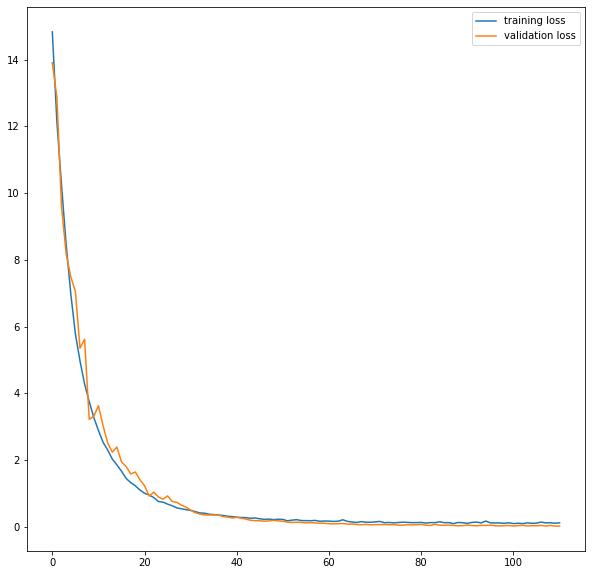

In [5]:
# Plot losses
plt.figure(figsize=(10, 10))
plt.plot(losses["train"], label="training loss")
plt.plot(losses["val"], label="validation loss")
plt.legend()
plt.show()

In [6]:
# Saving trained model
torch.save(trained_model, "orthogonal_autoencoder.pt")

In [7]:
# Computing integrated gradients of the encoder network
base = x1.mean(axis=0)
example = x2[0]
int_grads_tr, _ = get_integrated_gradients(model=trained_model, inp=example, baseline=base, steps=20)
int_grads_mc, _ = get_integrated_gradients_mc(model=trained_model, inp=example, baseline=base, samples=100)

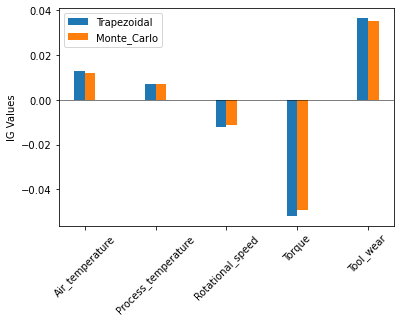

In [8]:
# Plotting integrated gradients
create_grouped_bar_plot(df_train.columns, Trapezoidal=int_grads_tr, Monte_Carlo=int_grads_mc)